<a href="https://colab.research.google.com/github/sahug/ds-bert/blob/main/BERT%20NLP%20-%20Text%20Classification%20Using%20BERT%20and%20Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERT NLP - Text Classification Using BERT and Tensorflow**

In [ ]:
%pip install -U -q tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding="ISO-8859-1")

In [ ]:
df.head()

,Category,Message,A,B,C
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#Drop unwanted columns
df = df.drop(["A",	"B",	"C"], axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#Review Dataset
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
#Since we have unballanced data. We will have to balance it.
df_spam = df[df['Category'] == "spam"]
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsample = df_ham.sample(df_spam.shape[0])
df_ham_downsample.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
#Apply boolean encoding on spam and ham
df_balanced["spam"] = df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)
df_balanced.sample(10)

,Category,Message,spam
1690,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...,1
4868,ham,1. Tension face 2. Smiling face 3. Waste face ...,0
1119,spam,"Bored of speed dating? Try SPEEDCHAT, txt SPEE...",1
3054,spam,EASTENDERS TV Quiz. What FLOWER does DOT compa...,1
4340,ham,ÌÏ all write or wat..,0
929,spam,money!!! you r a lucky winner ! 2 claim your p...,1
1698,spam,"Free msg. Sorry, a service you ordered from 81...",1
1779,spam,"Loan for any purpose å£500 - å£75,000. Homeown...",1
1063,spam,We have new local dates in your area - Lots of...,1
5497,spam,"SMS SERVICES. for your inclusive text credits,...",1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_text = train_test_split(df_balanced["Message"], df_balanced["spam"], stratify=df_balanced["spam"])

In [ ]:
X_train.head(4)

2320        This pain couldn't have come at a worse time.
187     Please call our customer service representativ...
4405    As one of our registered subscribers u can ent...
2133    Spoke with uncle john today. He strongly feels...
Name: Message, dtype: object

In [ ]:
#Download pretrained process and encoder
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
from pandas.io.xml import preprocess_data
#Write a function to get the encoding out of pretrained model downloaded
def get_sentence_embeding(sentences):
  preprocess_text = bert_preprocess(sentences)
  return bert_encoder(preprocess_text)["pooled_output"]


In [ ]:
get_sentence_embeding([
                       "500$ discount. hurry up!",
                       "Are you up for a volleyball game tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7995451 , -0.41840777, -0.80555654, ..., -0.5952304 ,
        -0.70517206,  0.8829687 ],
       [-0.9008625 , -0.47827342, -0.8823059 , ..., -0.7808709 ,
        -0.72400814,  0.9222427 ]], dtype=float32)>

In [ ]:
#Lets try to see embeddings for some other words.
e = get_sentence_embeding([
                           "banana",
                           "grapes",
                           "mango",
                           "jeff bezos",
                           "elon musk",
                           "bill gates"
])
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606919 , -0.14219381,  0.4960461 , ...,  0.42165333,
        -0.532214  ,  0.80312175],
       [-0.86023223, -0.21242939,  0.4915689 , ...,  0.3979803 ,
        -0.60506296,  0.8447167 ],
       [-0.7128864 , -0.15463923,  0.38401636, ...,  0.352787  ,
        -0.5099134 ,  0.73474115],
       [-0.8253345 , -0.3555054 , -0.5906963 , ..., -0.01613662,
        -0.6141756 ,  0.87230295],
       [-0.7504134 , -0.26812598, -0.26689604, ...,  0.02839445,
        -0.5938098 ,  0.79749876],
       [-0.78544384, -0.299497  ,  0.41027427, ...,  0.5222542 ,
        -0.4957355 ,  0.81507534]], dtype=float32)>

In [ ]:
# Lets look at the similarity using cosine
from sklearn.metrics.pairwise import cosine_similarity

# If the output is near to 1 they are similar. You can check for other words.
cosine_similarity([e[0]], [e[1]]) 

array([[0.9911088]], dtype=float32)

In [ ]:
from numpy import dtype
# There are 2 types of model. Sequential and Functional. Here we will use functional model.

# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# NNL
nnl = tf.keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
nnl = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(nnl)

# Construct Final Model
model = tf.keras.Model(inputs=[text_input], outputs=[nnl])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
#Compile Model
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name="accuracy"),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 449s 13s/step - loss: 0.7204 - accuracy: 0.5152 - precision: 0.5159 - recall: 0.4929
Epoch 2/10
35/35 [==============================] - 434s 12s/step - loss: 0.5571 - accuracy: 0.7875 - precision: 0.7692 - recall: 0.8214
Epoch 3/10
35/35 [==============================] - 433s 12s/step - loss: 0.4774 - accuracy: 0.8232 - precision: 0.8209 - recall: 0.8268
Epoch 4/10
35/35 [==============================] - 433s 12s/step - loss: 0.4249 - accuracy: 0.8518 - precision: 0.8373 - recall: 0.8732
Epoch 5/10
35/35 [==============================] - 433s 12s/step - loss: 0.3787 - accuracy: 0.8902 - precision: 0.8840 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 433s 12s/step - loss: 0.3656 - accuracy: 0.8884 - precision: 0.8705 - recall: 0.9125
Epoch 7/10
35/35 [==============================] - 435s 12s/step - loss: 0.3387 - accuracy: 0.8964 - precision: 0.8841 - recall: 0.9125
Epoch 8/10
35/35 [=======================

In [ ]:
model.evaluate(X_test, y_text)

12/12 [==============================] - 146s 12s/step - loss: 0.3077 - accuracy: 0.8877 - precision: 0.8436 - recall: 0.9519


[0.3077334463596344,
 0.8877005577087402,
 0.8436018824577332,
 0.9518716335296631]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 146s 12s/step


In [ ]:
#Doing this beqacuse the y_predictyed has floating points and we need the output in 0 and 1. 
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_text, y_predicted)
cm

array([[154,  33],
       [  9, 178]])

Text(33.0, 0.5, 'truth')

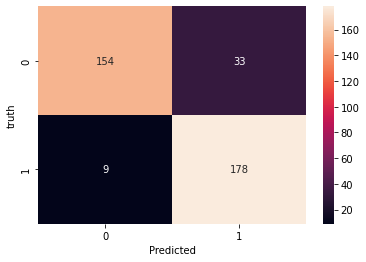

In [ ]:

from matplotlib import pyplot as plt 
import seaborn as sn
sn.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("truth")

In [ ]:
print(classification_report(y_text, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       187
           1       0.84      0.95      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374

